# Segmentação de imagens utilizando scikit-image

Tutorial SciPy 2019:
*   YouTube: https://youtu.be/d1CIV9irQAY
*   GitHub: https://github.com/scikit-image/skimage-tutorials




## Preparando os dados

Importando pasta pessoal do Google Drive contendo as imagens.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Importando as bibliotecas utilizadas no experimento.

In [0]:
# Importando bibliotecas
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
from matplotlib import pyplot as plt

Carregando uma imagem original da pupilometria.

*   Paciente: 12
*   Coleta: 2

In [0]:
from skimage import img_as_float

# Definindo funções para plotar imagens
def image_show(img, nrows=1, ncols=1, cmap='gray'):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    ax.imshow(img_as_float(img), cmap='gray');
    ax.axis('off')
    return fig, ax

def image_show_all(*images, titles=None, cmap='gray'):
    images = [img_as_float(img) for img in images]

    if titles is None:
        titles = [''] * len(images)
    vmin = min(map(np.min, images))
    vmax = max(map(np.max, images))
    ncols = len(images)
    height = 5
    width = height * len(images)
    fig, axes = plt.subplots(nrows=1, ncols=ncols,
                             figsize=(width, height))
    for ax, img, label in zip(axes.ravel(), images, titles):
        ax.imshow(img, vmin=vmin, vmax=vmax, cmap='gray')
        ax.set_title(label)

Type: <class 'numpy.ndarray'>
Data Type: float64
Shape: (480, 640)
Min/Max: 0.09217607843137254 0.9963690196078432


(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd413904198>)

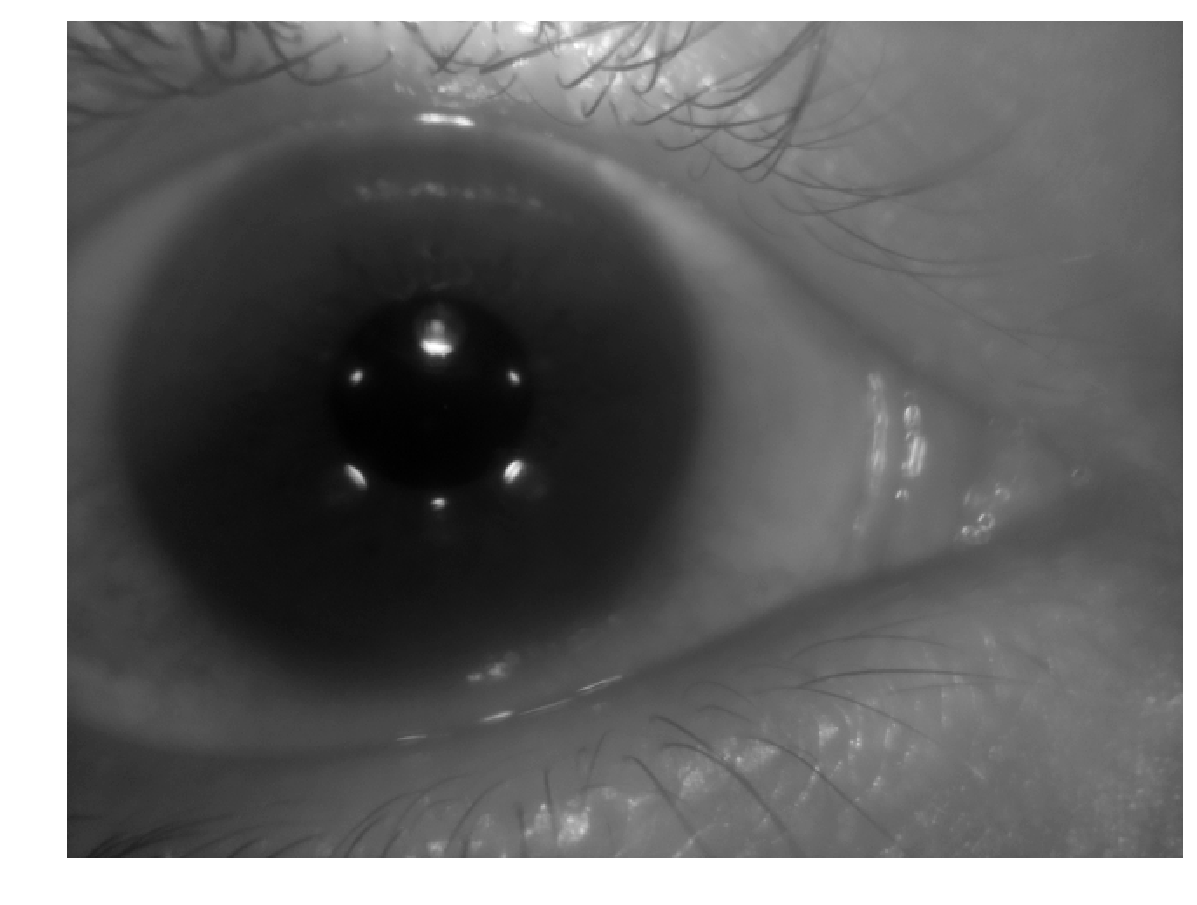

In [0]:
from skimage import io
from skimage import color

path = '/content/drive/My Drive/CI394 - Processamento de Imagens/Projeto/Images/'
filename = 'DATASET_12_12_2_frame_0000.jpg'
image_original = img_as_float(io.imread(path + filename))
image_gray = color.rgb2gray(image_original)
copy = image_gray.copy()

print('Type:', type(image_gray))
print('Data Type:', image_gray.dtype)
print('Shape:', image_gray.shape)
print('Min/Max:', image_gray.min(), image_gray.max())

image_show(image_gray)

## Pré-Processamento

**Filtro da média ou filtro gaussiano?**

O filtro gaussiano não é drasticamente diferente do filtro da média, mas o filtro gaussiano é geralmente preferido por causa da ponderação dependente da distância e porque não possui transições nítidas (considere o que acontece no domínio de Fourier).

In [0]:
import skimage.filters as filters
from skimage.morphology import disk

# Criando o elemento estruturante
neighborhood = disk(radius=6)

mean = filters.rank.mean(copy, neighborhood)
gaussian = filters.gaussian(copy, sigma=1)
median = filters.rank.median(copy, neighborhood)

image_show_all(copy, mean, gaussian, median, titles=['Original', 'Média', 'Gaussiano', 'Mediana'])

NameError: ignored

**Histograma**

Uma das ferramentas mais comuns para avaliar a exposição é o *histograma*, que plota o número de pontos que têm um certo valor em relação aos valores na ordem do mais baixo (escuro) ao mais alto (claro).

In [0]:
def plot_img_and_hist(image, axes, bins=256):
    """
    Plot an image along with its histogram and cumulative histogram.
    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Mostra a imagem
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Mostra o histograma
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Mostra a distribuição cumulativa
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

In [0]:
from skimage import exposure

img = copy.copy()

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalização
img_eq = exposure.equalize_hist(img)

# Equalização adaptativa
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

NameError: ignored

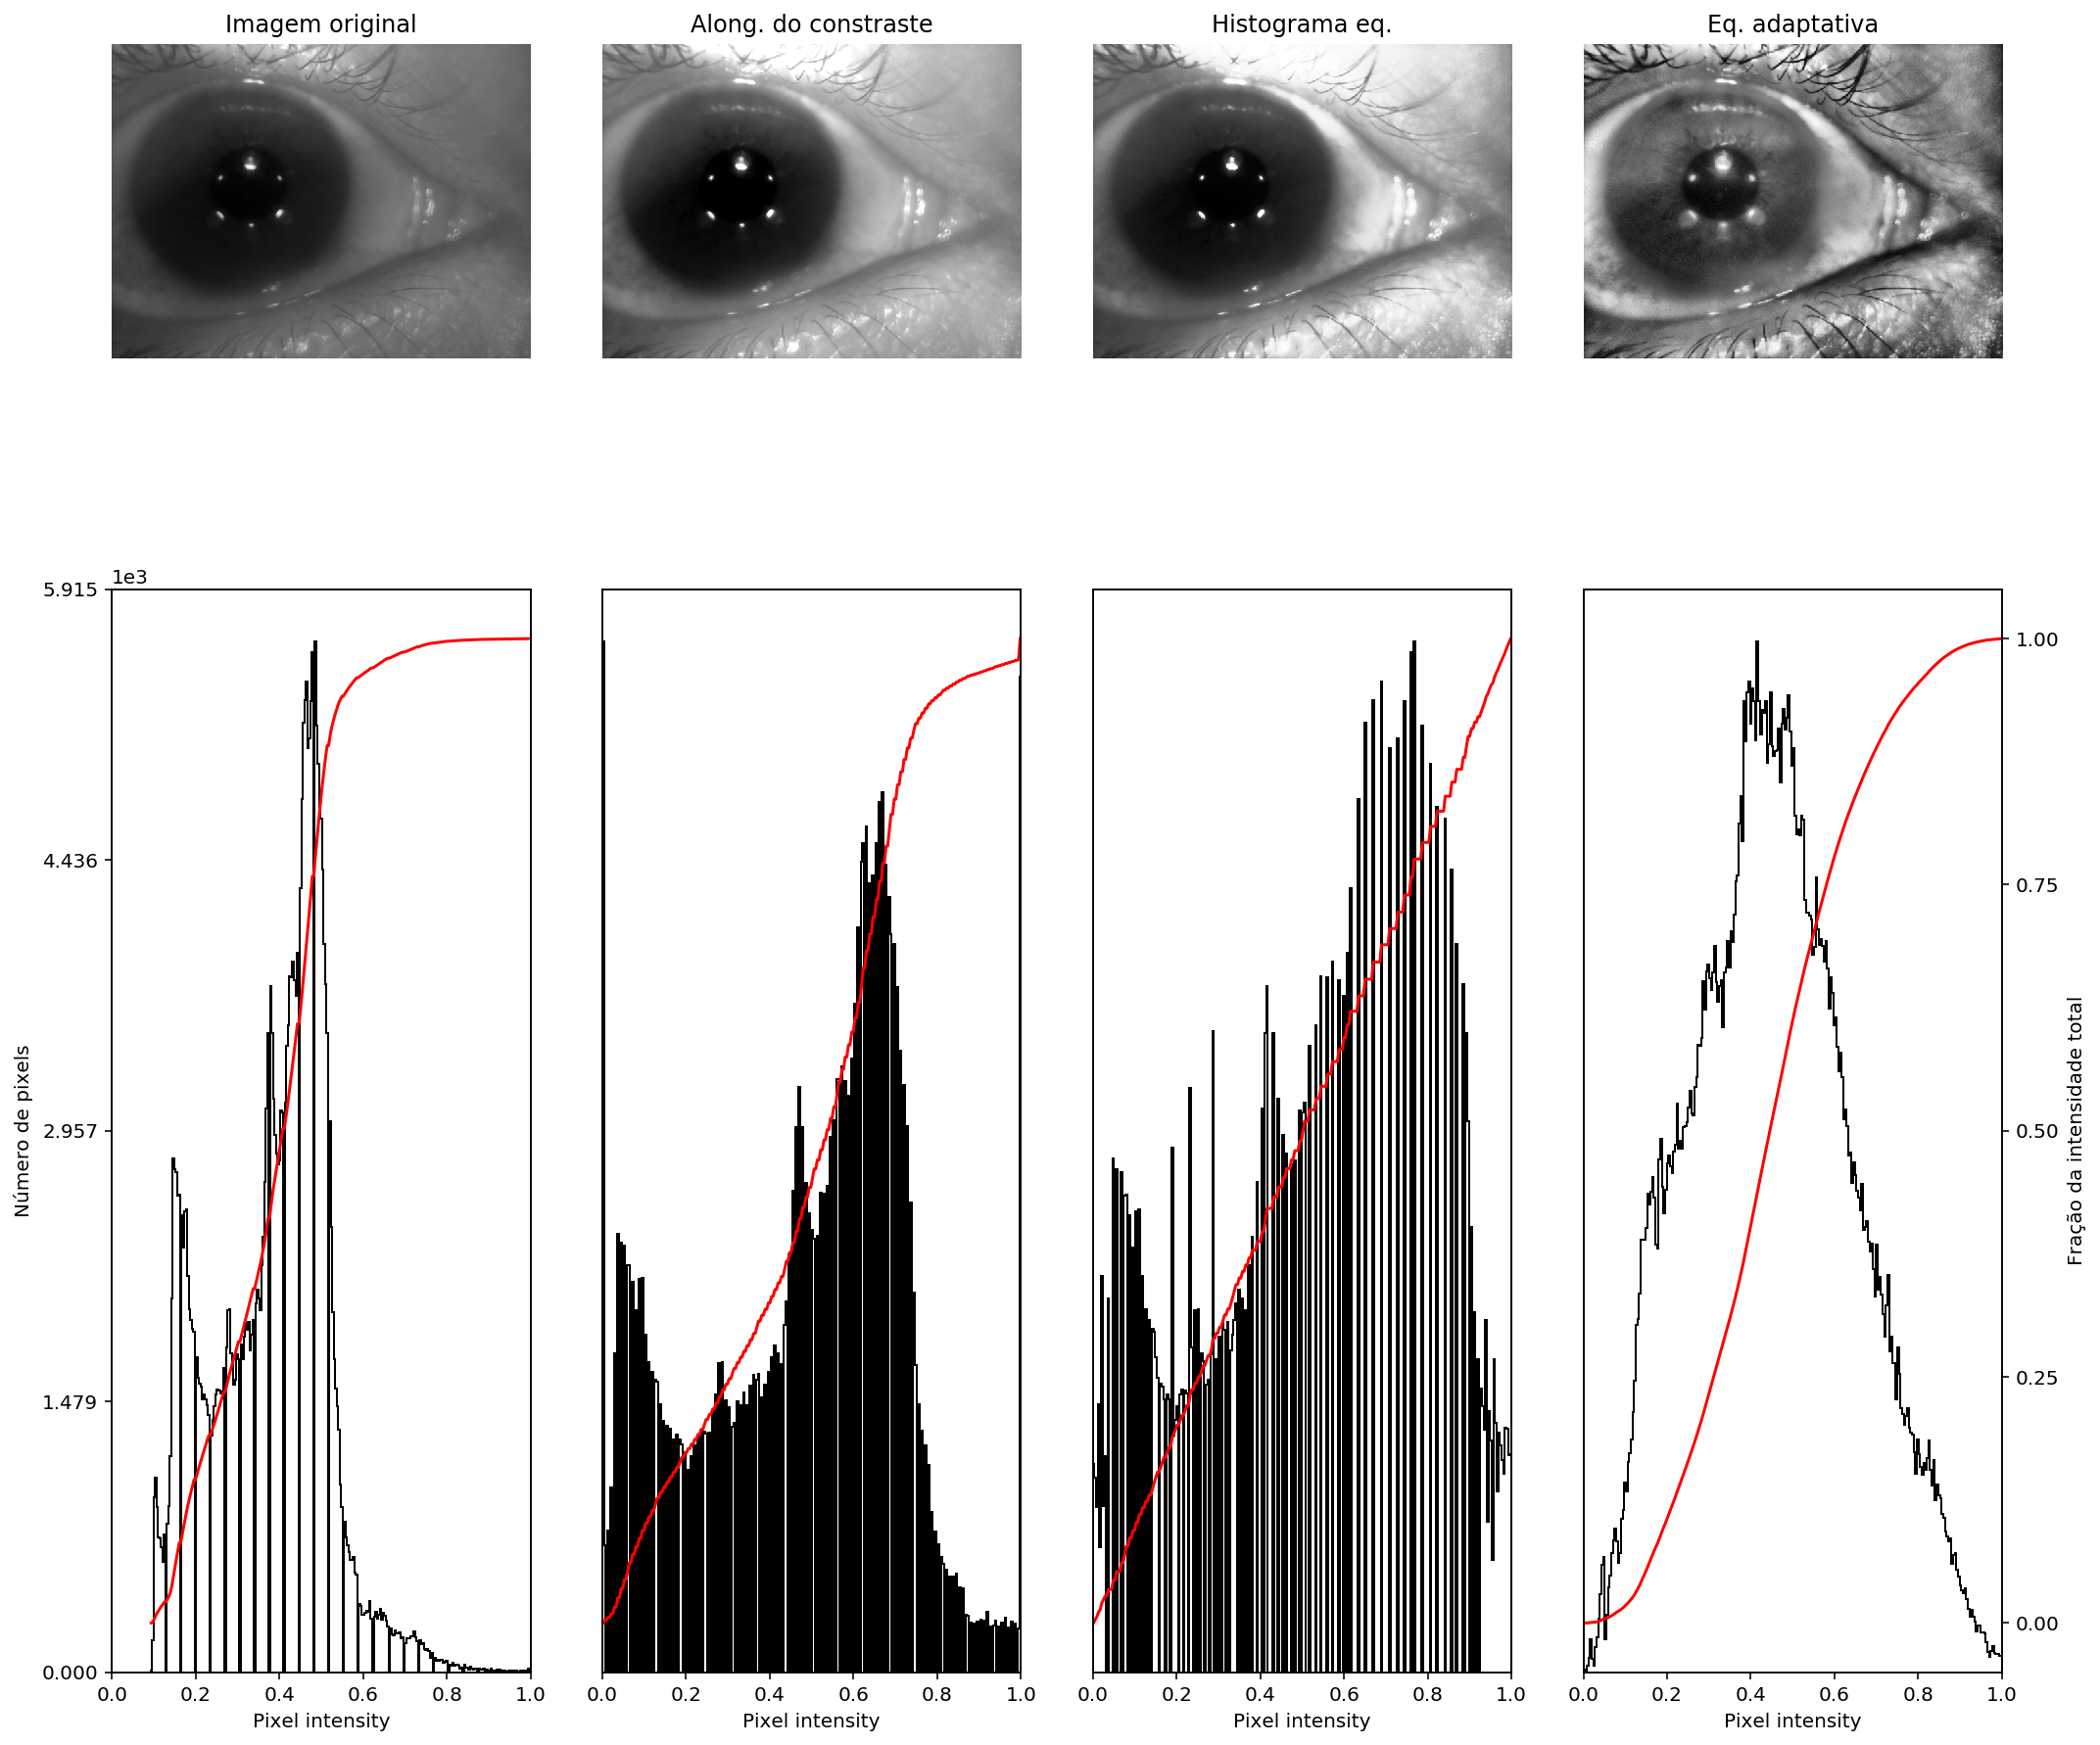

In [0]:
# Mostrando os resultados
fig = plt.figure(figsize=(15, 15))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, 
                                 sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Imagem original')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Número de pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Along. do constraste') # Alongamento do contraste

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histograma eq.') # Histograma equalizado

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Eq. adaptativa') # Equalização adaptativa

ax_cdf.set_ylabel('Fração da intensidade total')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# Sem overlap nos rótulos do eixo y
fig.tight_layout();

**Detecção de bordas**

Para imagens, as bordas são limites entre valores claros e escuros. A detecção de arestas pode ser útil por si só, ou pode ser usada como etapa preliminar em outros algoritmos.

Pode-se pensar em uma aresta como pontos em que o gradiente é grande em uma direção. É possível aproximar gradientes com filtros de diferença.

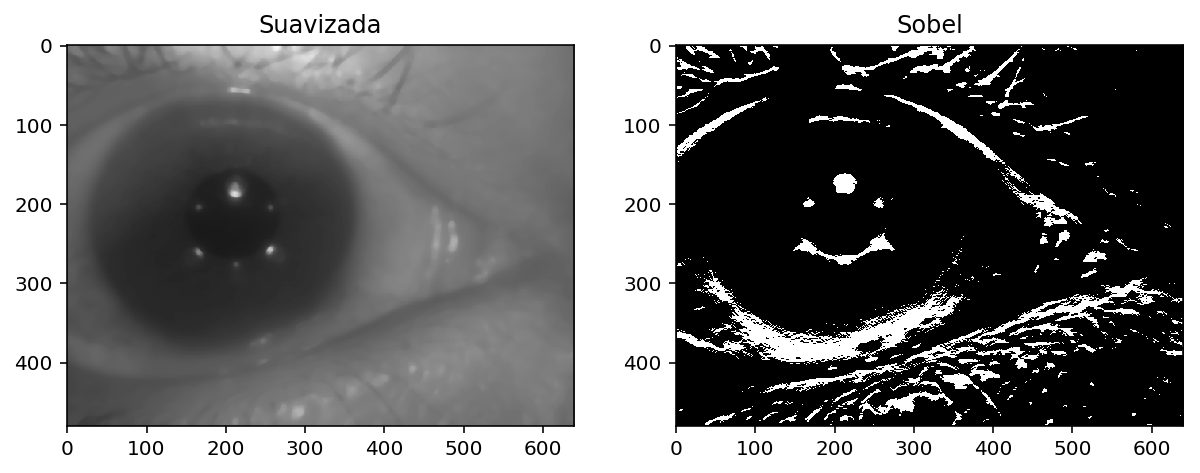

In [0]:
# Escolhendo o filtro suavizador com melhor desempenho
smooth = median.copy()

sobel = filters.sobel_h(smooth) > 0.005
image_show_all(smooth, sobel, titles=['Suavizada', 'Sobel'])

**Canny**

O filtro Canny é um detector de borda de vários estágios. Ele usa um filtro baseado na derivada de um gaussiano para calcular a intensidade dos gradientes. O gaussiano reduz o efeito do ruído presente na imagem. Em seguida, as arestas em potencial são reduzidas para curvas de 1 pixel removendo pixels não máximos da magnitude do gradiente. Finalmente, os pixels das bordas são mantidos ou removidos usando limiar de histerese na magnitude do gradiente.

Canny possui três parâmetros ajustáveis: a largura do gaussiano (quanto mais ruidosa a imagem, maior a largura) e o limiar baixo e alto para o limiar da histerese.

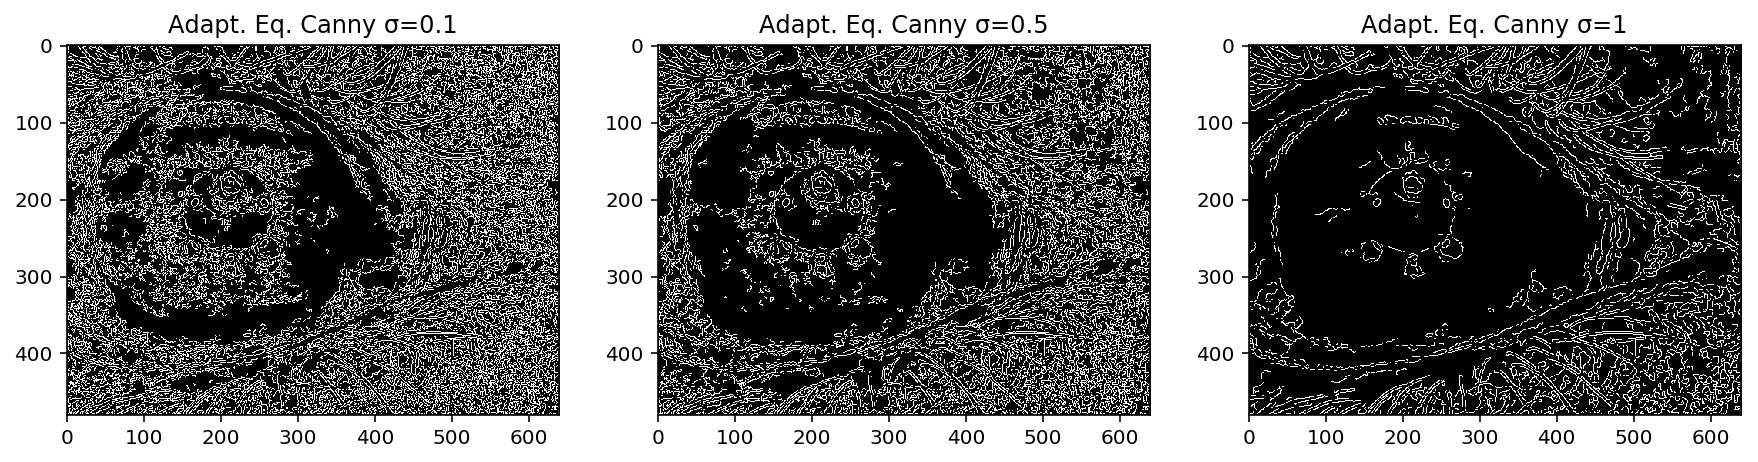

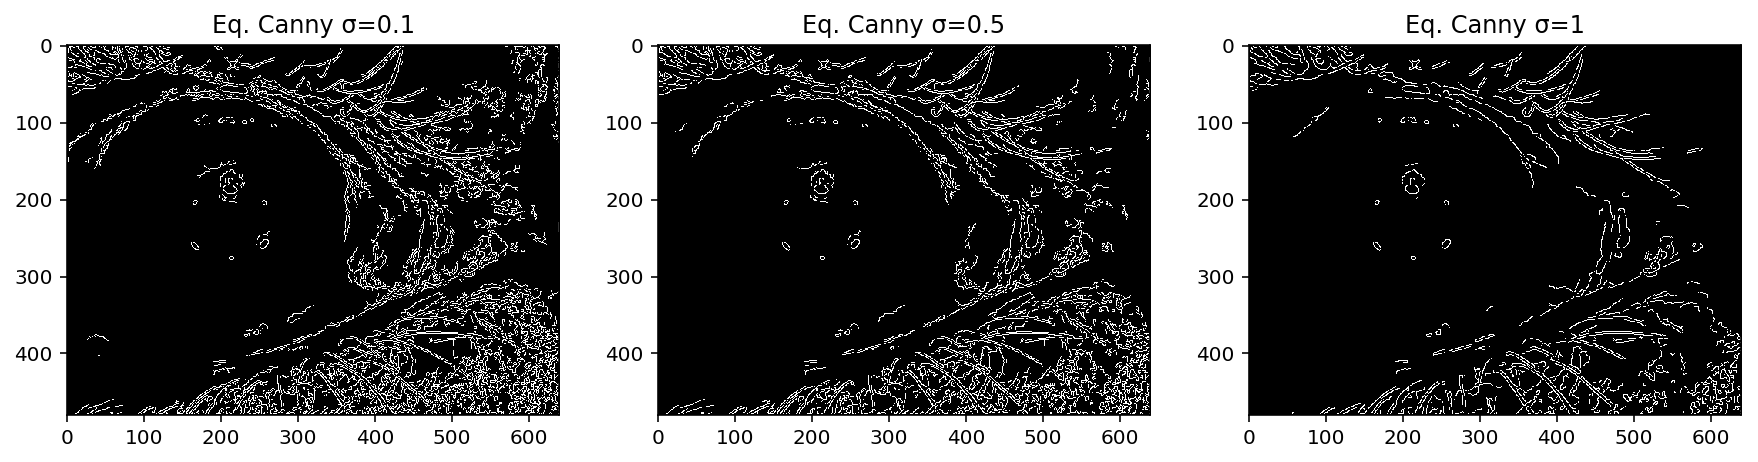

In [0]:
from skimage import feature

image_show_all(feature.canny(img_adapteq, sigma=0.1), feature.canny(img_adapteq, sigma=0.5), 
               feature.canny(img_adapteq, sigma=1), 
               titles=['Adapt. Eq. Canny σ=0.1', 'Adapt. Eq. Canny σ=0.5', 'Adapt. Eq. Canny σ=1'])

image_show_all(feature.canny(img_eq, sigma=0.1), feature.canny(img_eq, sigma=0.5),
               feature.canny(img_eq, sigma=1), 
               titles=['Eq. Canny σ=0.1', 'Eq. Canny σ=0.5', 'Eq. Canny σ=1'])

## Segmentação

Segmentação pode ser divida em dois grupos principais:

**Segmentação Supervisionada**
*   Algoritmos de thresholding com entrada do usuário (skimage.filters.threshold_*)
*   skimage.segmentation.random_walker
*   skimage.segmentation.active_contour
*   skimage.segmentation.watershed

**Segmentação Não Supervisionada**
*   Algoritmos de thresholding sem entrada do usuário
*   skimage.segmentation.slic
*   skimage.segmentation.chan_vese
*   skimage.segmentation.felzenszwalb
*   skimage.segmentation.quickshift

### Segmentação Supervisionada

**Threshold a partir do histograma**

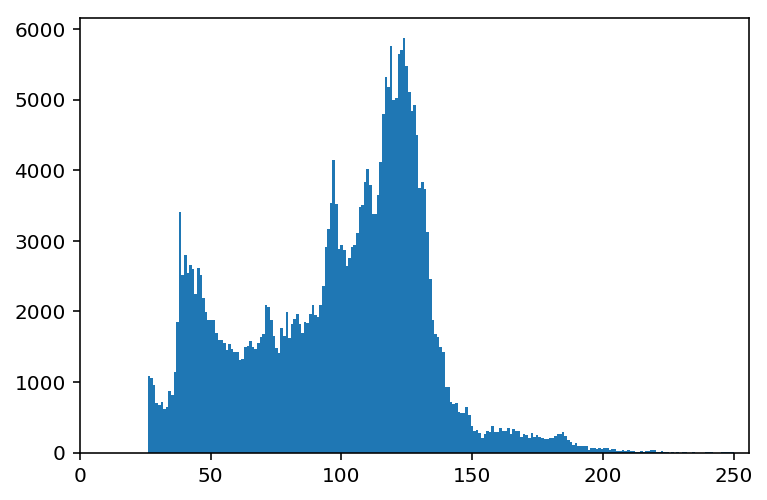

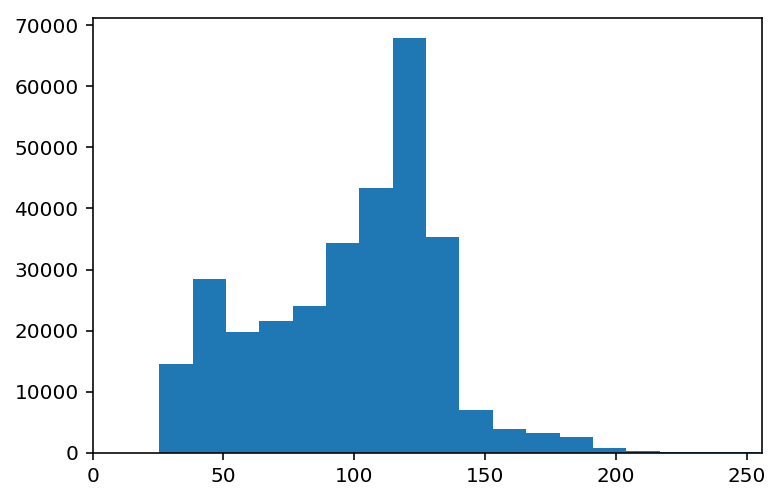

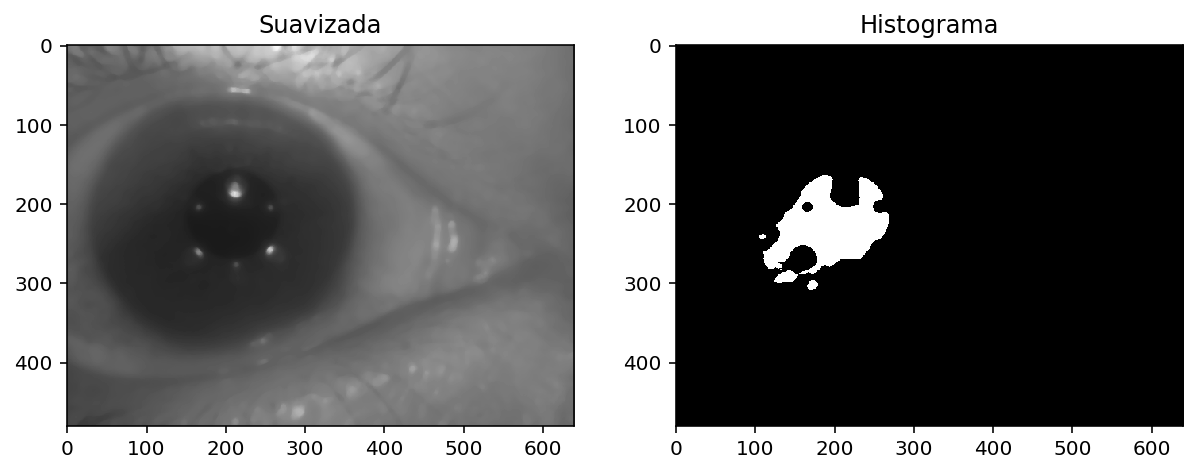

In [0]:
# Threshold Supervisionado
smooth = median.copy()

fig, ax = plt.subplots(1, 1)
ax.hist(smooth.ravel(), bins=256, range=[0, 255])
ax.set_xlim(0, 256);

fig, ax = plt.subplots(1, 1)
ax.hist(smooth.ravel(), bins=20, range=[0, 255])
ax.set_xlim(0, 256);

hist, bin_edges = np.histogram(smooth.ravel(), bins=20)
thresh_hist = smooth < bin_edges[1]
image_show_all(smooth, thresh_hist, titles=['Suavizada', 'Histograma'])

skimage.filters.thresholding.threshold_isodata
skimage.filters.thresholding.threshold_li
skimage.filters.thresholding.threshold_mean
skimage.filters.thresholding.threshold_minimum
skimage.filters.thresholding.threshold_otsu
skimage.filters.thresholding.threshold_triangle
skimage.filters.thresholding.threshold_yen


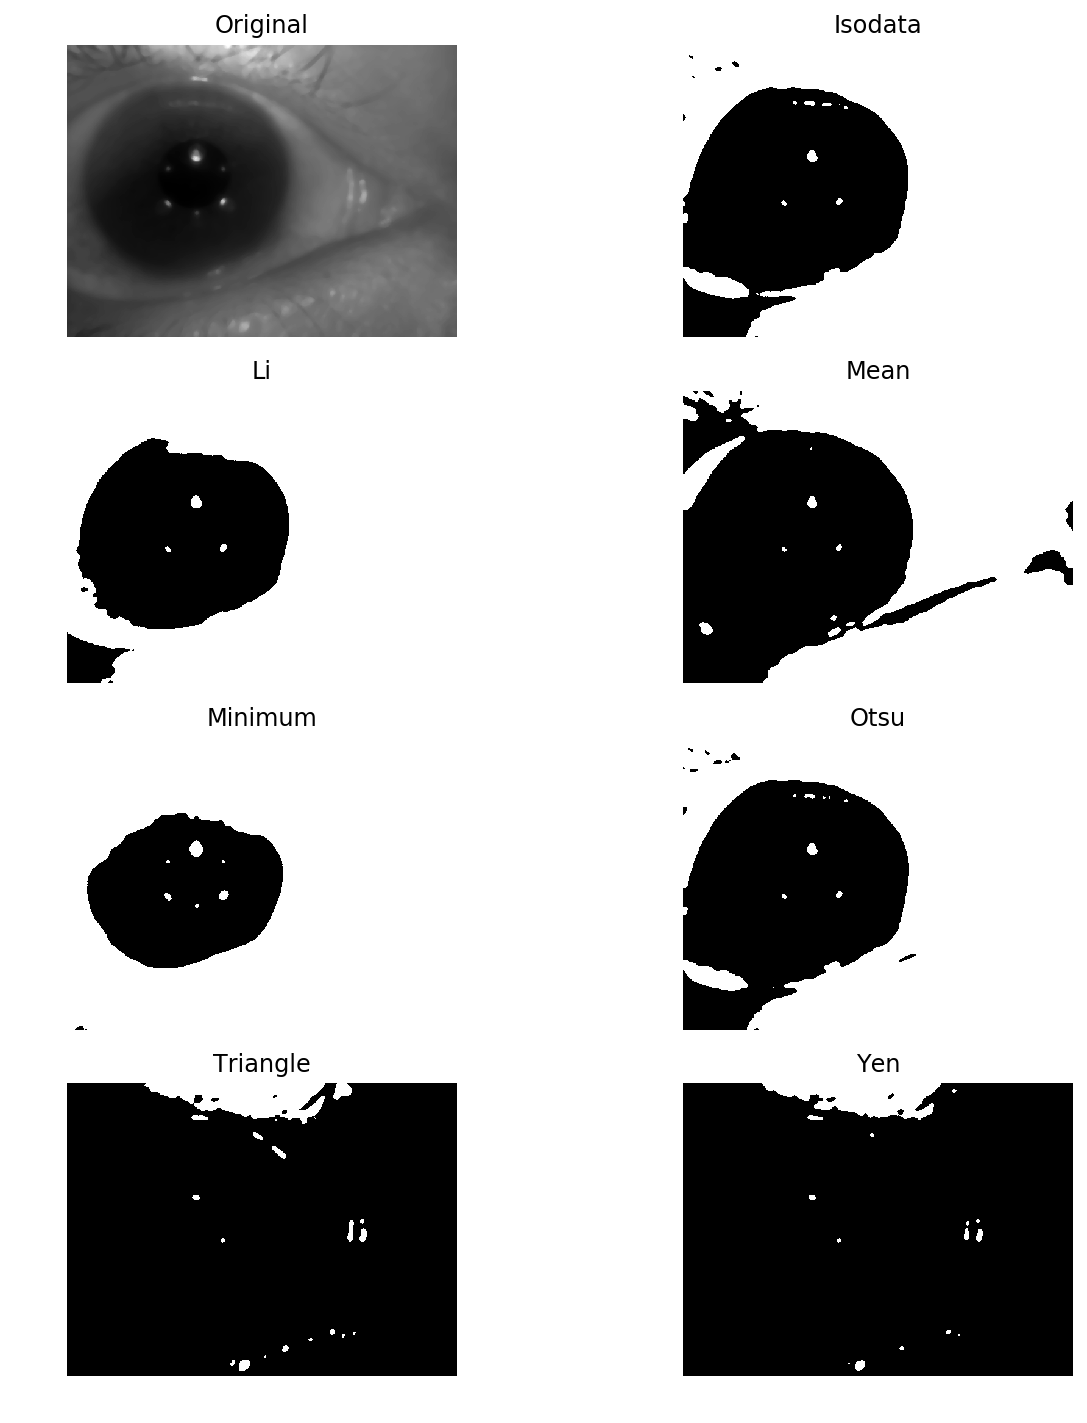

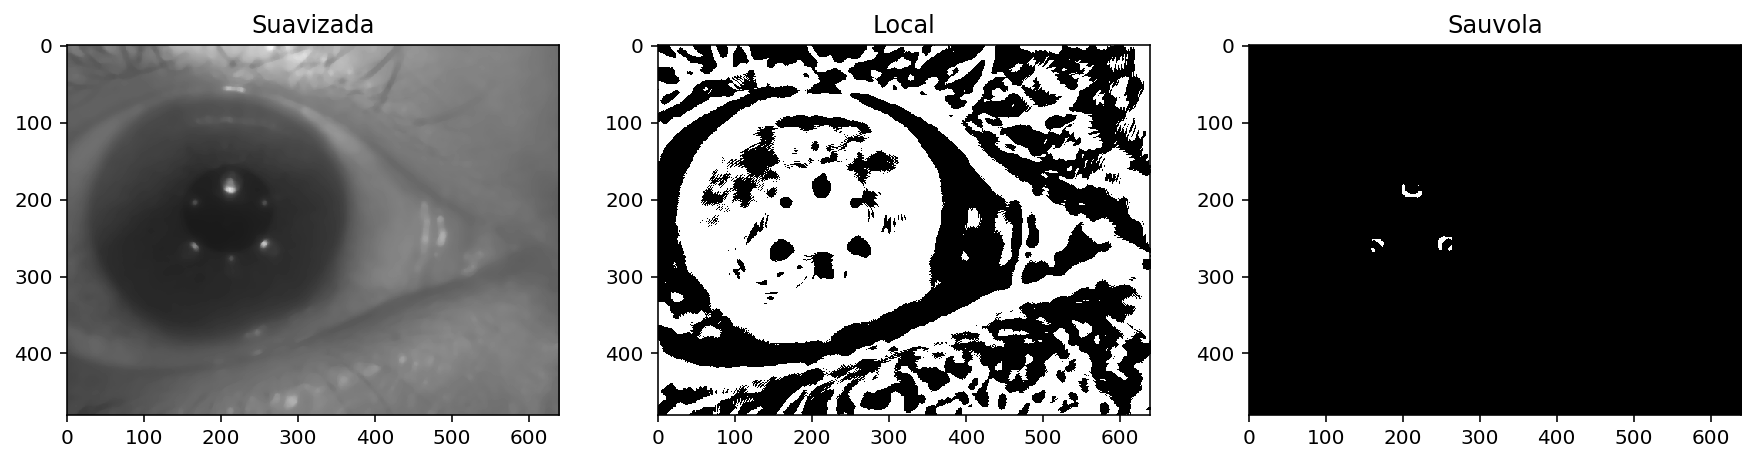

In [0]:
# Threshold Não Supervisionado
filters.try_all_threshold(smooth, figsize=(10, 10));

local = smooth < filters.threshold_local(smooth, block_size=99)
sauvola = smooth < filters.threshold_sauvola(smooth)

image_show_all(smooth, local, sauvola, titles=['Suavizada', 'Local', 'Sauvola'])

**Morfologia**

In [0]:
def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

**Erosão**

A erosão morfológica define um pixel em (i, j) para o mínimo sobre todos os pixels na vizinhança centralizada em (i, j). A erosão diminui as regiões brilhantes e amplia as regiões escuras.

O elemento estruturador, `selem`, passado para a erosão é uma matriz booleana que descreve essa vizinhança. Abaixo, usamos `disk` para criar um elemento estruturador circular, usado na maioria dos exemplos a seguir.

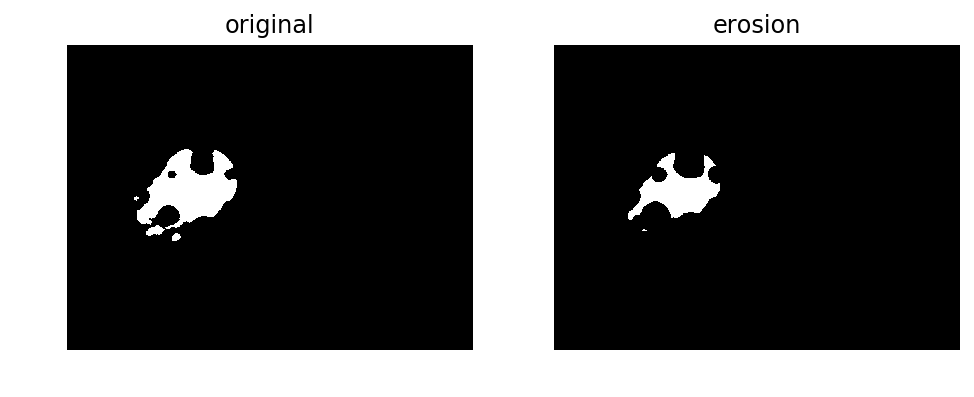

In [0]:
from skimage import morphology as morph

img_morph = thresh_hist.copy()

selem = morph.disk(6)
eroded = morph.erosion(img_morph, selem)
plot_comparison(img_morph, eroded, 'erosion')

**Dilatação**

A "dilatação" morfológica define um pixel em (i, j) para o máximo sobre todos os pixels na vizinhança centralizada em (i, j). A dilatação aumenta as regiões claras e reduz as regiões escuras.

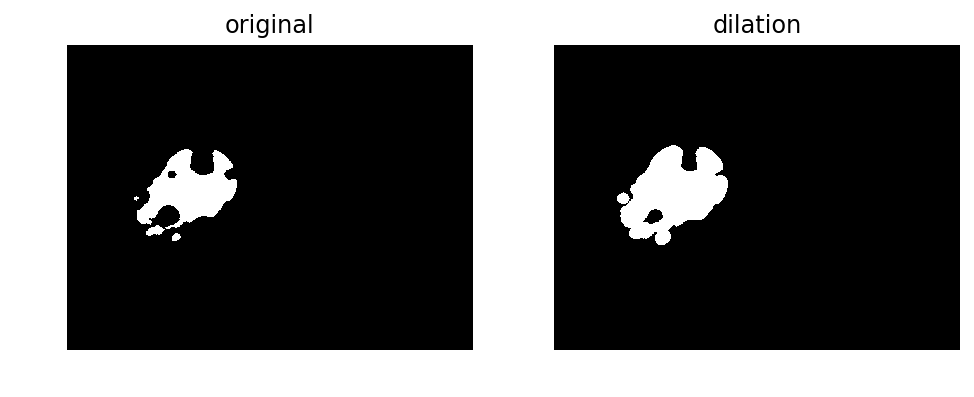

In [0]:
dilated = morph.dilation(img_morph, selem)
plot_comparison(img_morph, dilated, 'dilation')

**Abertura**

A "abertura" morfológica em uma imagem é definida como uma erosão seguida por uma dilatação. *A abertura pode remover pequenos pontos brilhantes e conectar pequenas rachaduras escuras.*

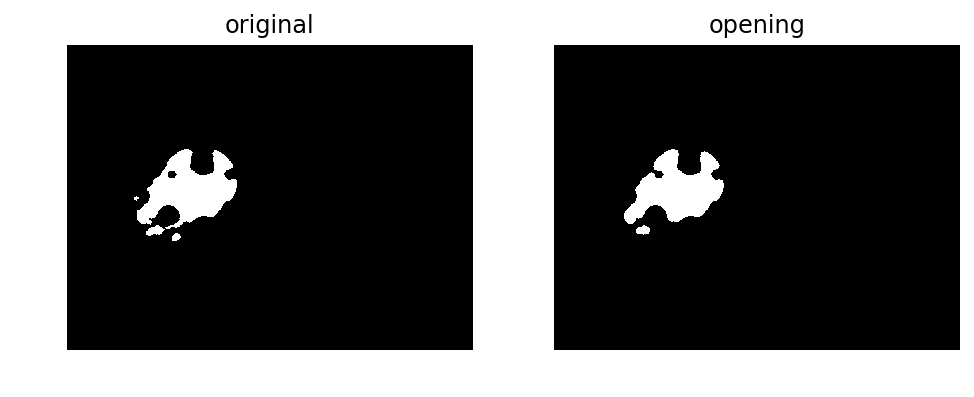

In [0]:
opened = morph.opening(img_morph, selem)
plot_comparison(img_morph, opened, 'opening')

**Fechamento**

O "fechamento" morfológico de uma imagem é definido como uma dilatação seguida de uma erosão. *O fechamento pode remover pequenos pontos escuros e conectar pequenas rachaduras brilhantes.*

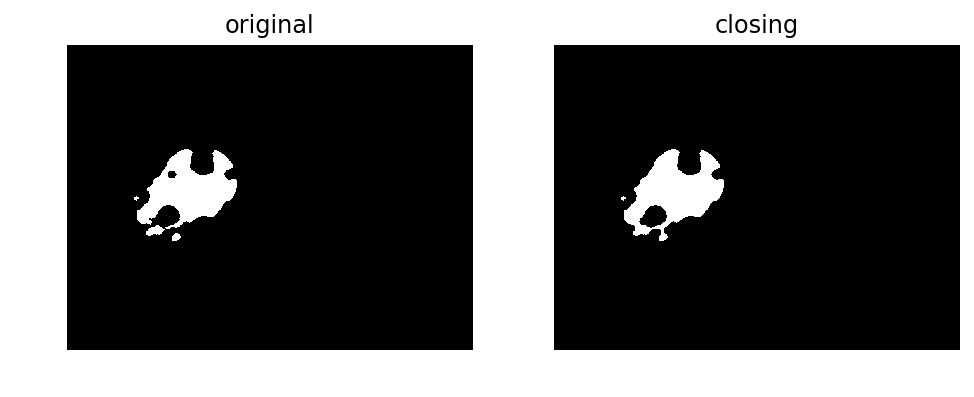

In [0]:
closed = morph.closing(img_morph, selem)
plot_comparison(img_morph, closed, 'closing')

**White Tophat**

O `white_tophat` de uma imagem é definido como a imagem menos sua abertura morfológica. *Esta operação retorna os pontos brilhantes da imagem que são menores que o elemento estruturador.*

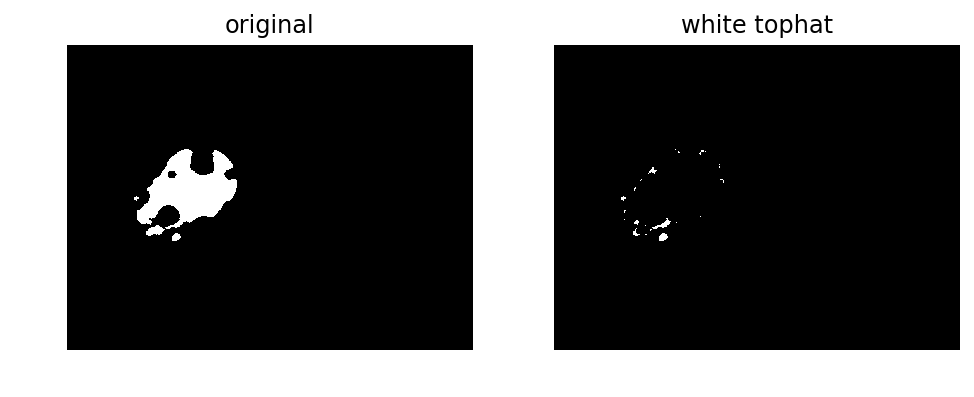

In [0]:
w_tophat = morph.white_tophat(img_morph, selem)
plot_comparison(img_morph, w_tophat, 'white tophat')

**Black Tophat**

O `black_tophat` de uma imagem é definido como seu fechamento morfológico menos a imagem original. *Esta operação retorna os pontos escuros da imagem que são menores que o elemento estruturador.*

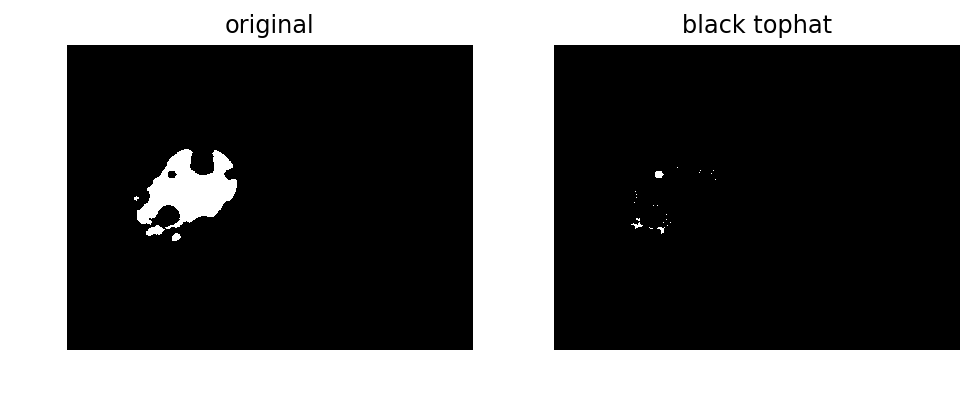

In [0]:
b_tophat = morph.black_tophat(img_morph, selem)
plot_comparison(img_morph, b_tophat, 'black tophat')

**Active Contour (Contorno Ativo)**

Inicializa usando um contorno ou linha definida pelo usuário, que é atraída por bordas e/ou brilho. Pode ser ajustado para muitas situações, mas o contraste misto pode ser problemático.

É necessário ter um conjunto de parâmetros iniciais para "semear" nossa segmentação. Isso pode ser feito interativamente, com um GUI ou determinado arbitrariamente.

In [0]:
def circle_points(resolution, center, radius):
    """
    Generate points defining a circle on an image.
    """
    radians = np.linspace(0, 2*np.pi, resolution)

    c = center[1] + radius*np.cos(radians)
    r = center[0] + radius*np.sin(radians)
    
    return np.array([c, r]).T

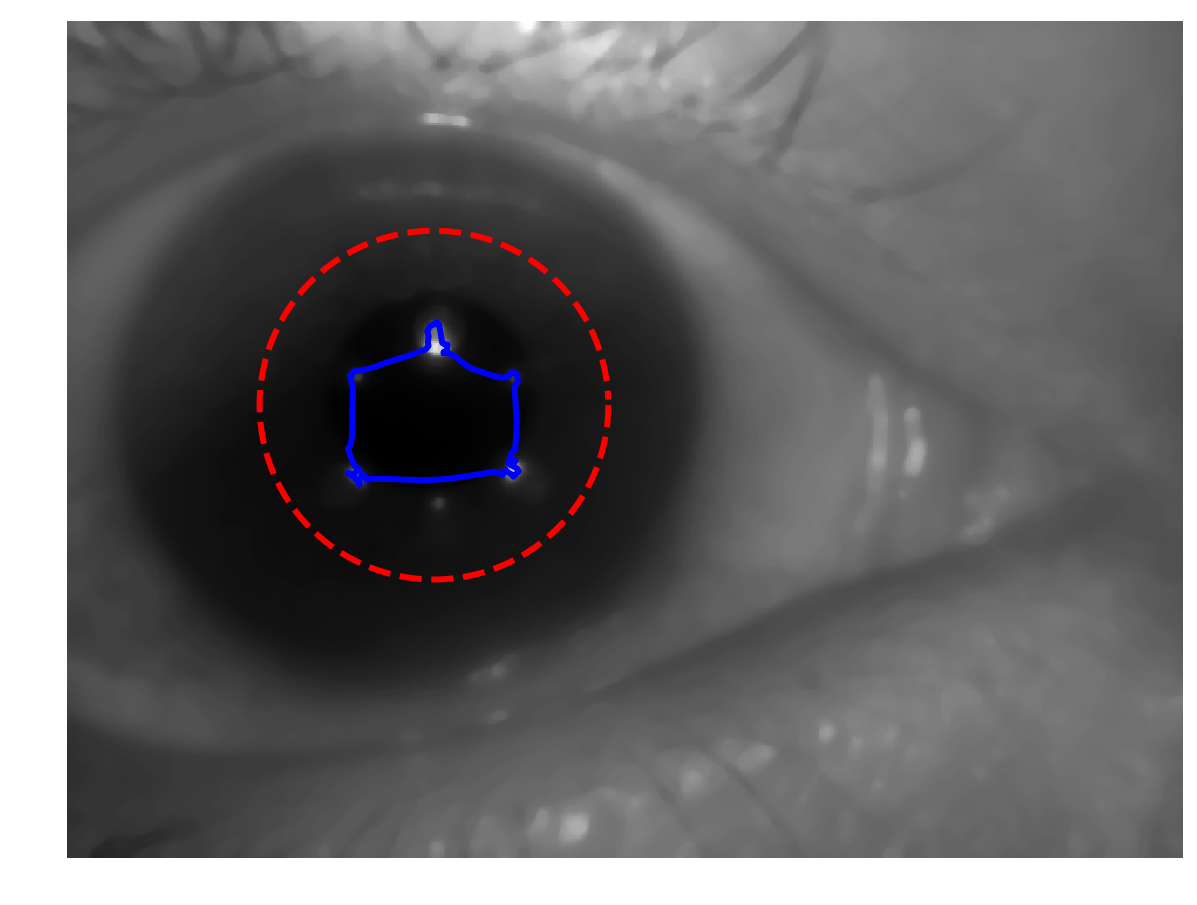

In [0]:
import skimage.segmentation as seg

smooth = median.copy()

# Coordenadas da pupila
center = [220, 210]
radius = 100

# Exclui o último ponto porque um caminho fechado não pode ter pontos duplicados
points = circle_points(200, center, radius)[:-1]

snake = seg.active_contour(smooth, points, alpha=0.1, w_edge=10)

fig, ax = image_show(smooth)
ax.plot(points[:, 0], points[:, 1], '--r', lw=3)
ax.plot(snake[:, 0], snake[:, 1], '-b', lw=3);

**Random Walker (Caminhante Aleatório)**

Inicializado usando qualquer ponto rotulado, preenche a imagem com o rótulo que parece menos distante do ponto de origem (em um caminho ponderado pelas diferenças de pixel). Tende a respeitar arestas ou degraus, e é surpreendentemente robusto ao ruído. Apenas um parâmetro para ajustar.

Uma boa analogia para caminhante aleatório usa a teoria dos grafos.

* A distância de cada pixel aos seus vizinhos é ponderada pelo quão semelhantes são seus valores; quanto mais semelhante, menor é o custo de passar de um para outro;
* O usuário fornece alguns pontos de propagação;
* O algoritmo encontra os caminhos mais baratos de cada ponto para cada valor inicial;
* Os pixels são rotulados com o caminho mais barato / mais baixo.

O algoritmo de caminhante aleatório espera uma imagem rotulada como entrada. Qualquer rótulo acima de zero será tratado como uma semente; todos os locais com valor zero serão preenchidos com rótulos dos números inteiros positivos disponíveis.

Há também um recurso de máscara em que qualquer coisa rotulada com -1 nunca será rotulada ou atravessada. Esse recurso não é usado aqui.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd413e5d898>)

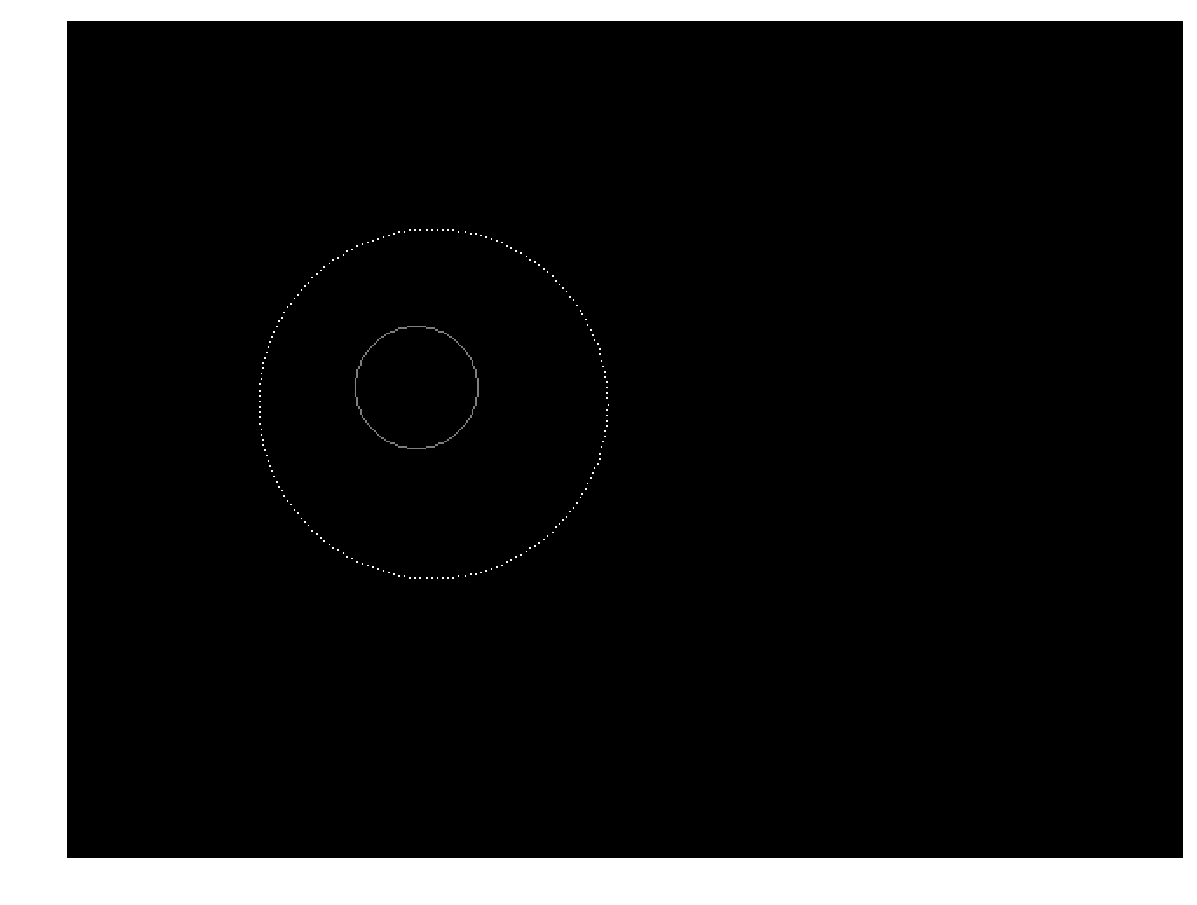

In [0]:
import skimage.draw as draw

image_labels = np.zeros(smooth.shape, dtype=np.uint8)

x = smooth.shape[0] // 2 - 30
y = smooth.shape[1] // 2 - 120
radius = 35

indices = draw.circle_perimeter(x, y, radius)
image_labels[indices] = 1
image_labels[points[:, 1].astype(np.int), points[:, 0].astype(np.int)] = 2

image_show(image_labels)

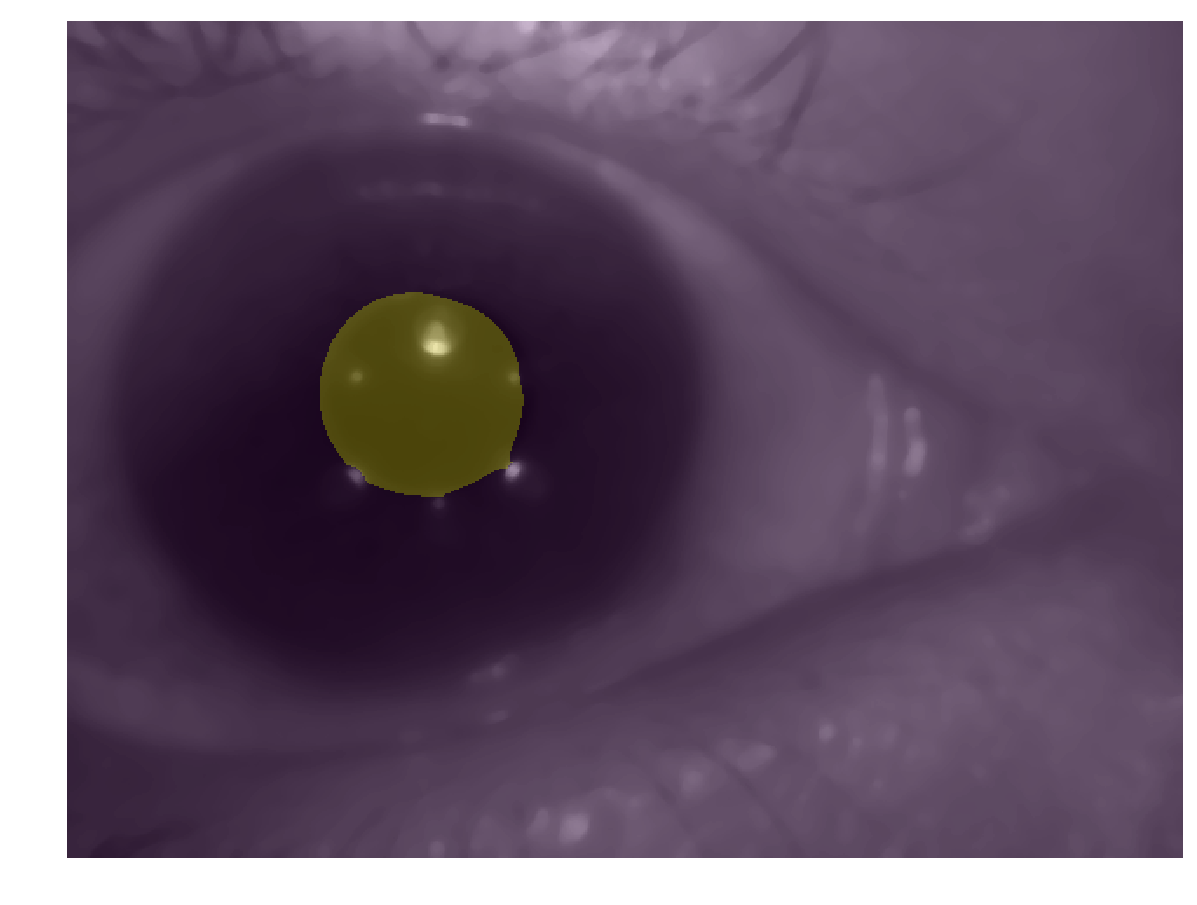

In [0]:
image_segmented = seg.random_walker(smooth, image_labels, beta=2500)

fig, ax = image_show(smooth)
ax.imshow(image_segmented == 1, alpha=0.3)

**Flood Fill**

Pegam um ponto inicial e iterativamente encontram e preenchem pontos adjacentes iguais ou dentro de uma tolerância do ponto inicial. "flood()" retorna a região; "flood_fill()" retorna uma imagem modificada com esses pontos alterados para um novo valor.

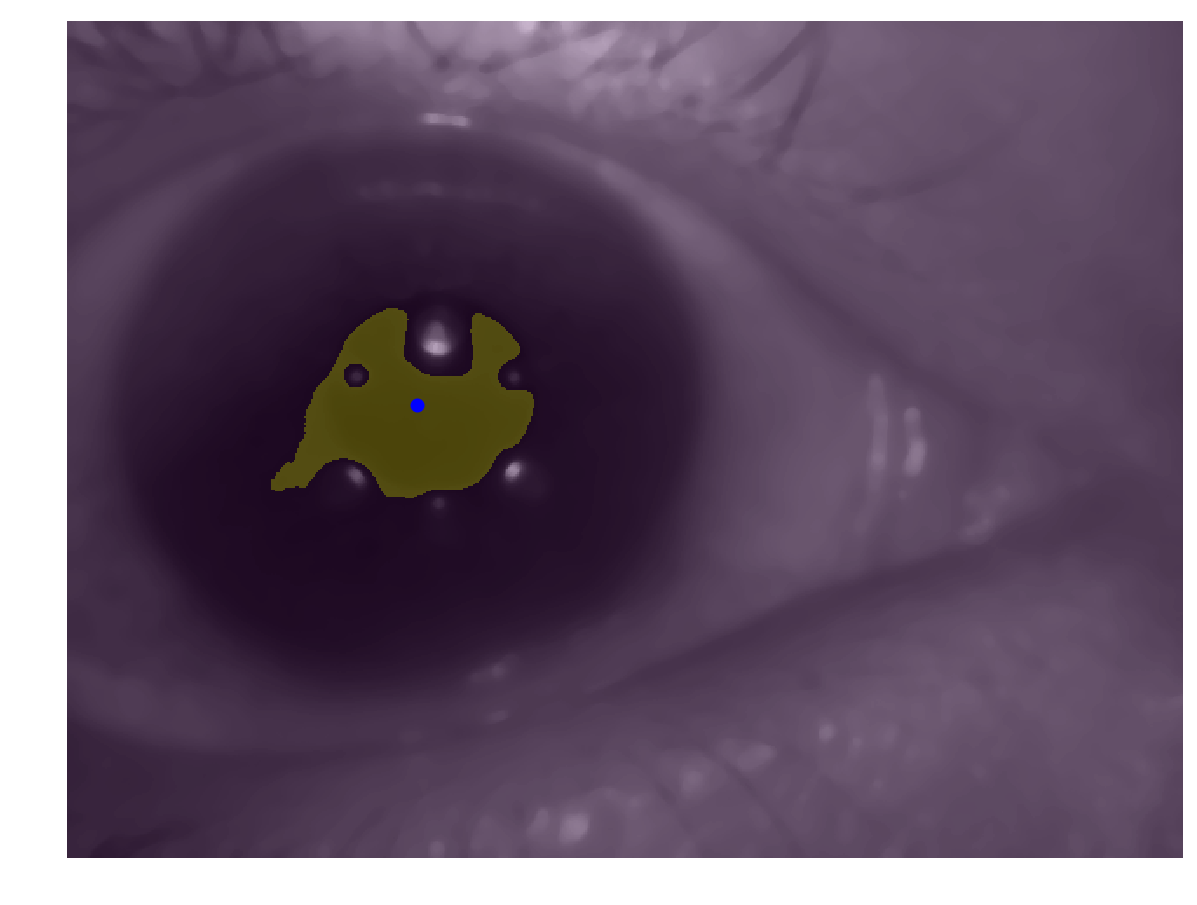

In [0]:
seed_point = (220, 200)
flood_mask = seg.flood(smooth, seed_point, tolerance=8)

fig, ax = image_show(smooth)
ax.imshow(flood_mask, alpha=0.3);
ax.plot(200, 220, 'bo')

### Segmentação Não-Supervisionada

A segmentação não supervisionada pode então dividir a imagem em várias sub-regiões; portanto, em vez de milhões de pixels, você tem dezenas a centenas de regiões.

**SLIC**

Existem muitas analogias para aprendizagem de máquina na segmentação não supervisionada. O primeiro exemplo usa diretamente um algoritmo comum de aprendizado de máquina por baixo dos panos: K-Means.

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd415eb1d30>)

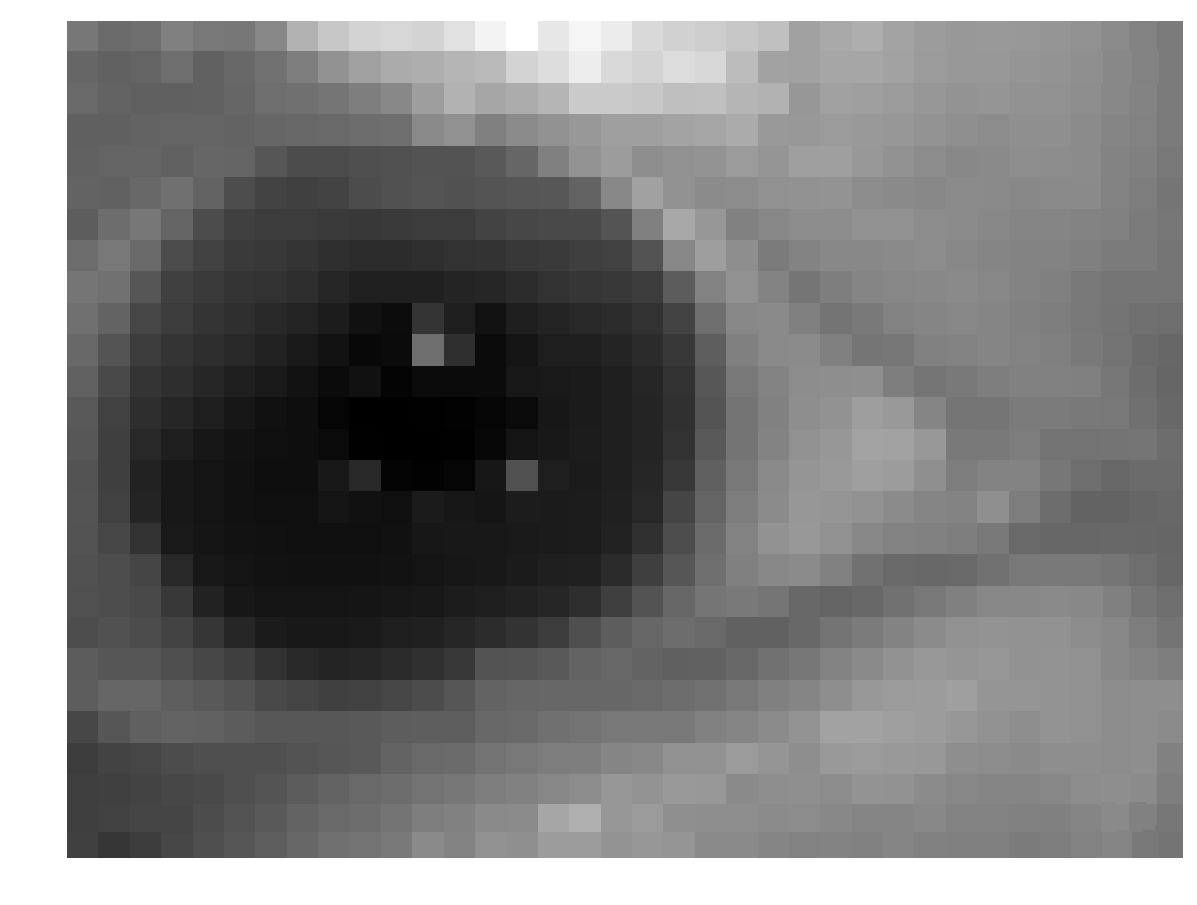

In [0]:
smooth = median.copy()

image_slic = seg.slic(smooth, n_segments=1000)

# label2rgb substitui cada rótulo discreto com o valor médio dos pixels internos da região
image_show(color.label2rgb(image_slic, smooth, kind='avg'))

**Chan-Vese**

Esse algoritmo itera um conjunto de níveis, que permite capturar recursos complexos e até desconectados. No entanto, seu resultado é binário - haverá apenas uma região - e requer uma imagem em escala de cinza.

O algoritmo leva alguns segundos para ser executado.

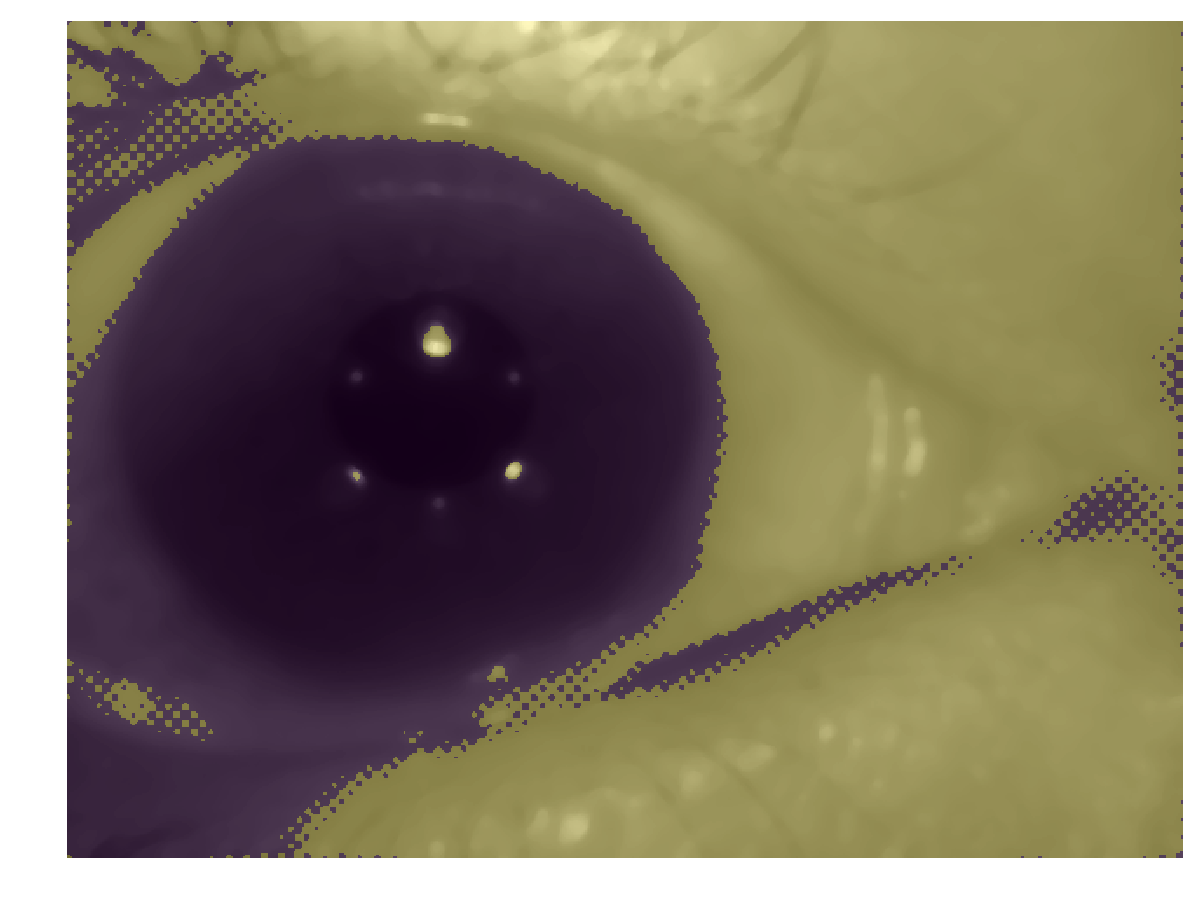

In [0]:
chan_vese = seg.chan_vese(smooth)

fig, ax = image_show(smooth)
ax.imshow(chan_vese == 0, alpha=0.3)

### Extração de Características

*   `regionprops`: 

http://scikit-image.org/docs/dev/api/skimage.measure.html#skimage.measure.regionprops

In [0]:
import skimage.measure as measure

# Regionprops ignora zeros
regions = measure.regionprops(image_slic)

print(len(regions))

971
